In [1]:
# All of our dependencies
import numpy as np
import pandas as pd

import os

import torch
from torch import optim
from torch import nn

import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Mount google drive in order to be able to use files here
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
# PyTorch seed for reproducibility
# torch.manual_seed(0)

# Our genres
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 
                'metal', 'pop', 'reggae', 'rock']

# MusicDS class to handle the data
class MusicDS(Dataset):
    def __init__(self, path):
        labels = os.listdir(path)
        self.idx_to_labels = {k:v for k, v in enumerate(labels)}
        self.labels_to_idx = {v:k for k, v in enumerate(labels)}
        
        songs_lists = [os.listdir(path + l) for l in labels]
        songs_lists = [list(map(list, zip([path + labels[i] + '/' for a in range(len(sl))],sl))) for i,sl in enumerate(songs_lists)]
        labels = np.array([[s[0].split('/')[-2] for s in l] for l in songs_lists])
        labels = labels.reshape(labels.shape[0] * labels.shape[1])
        
        songs_lists = np.array([[s[0] + s[1] for s in l] for l in songs_lists])
        songs_lists = songs_lists.reshape(songs_lists.shape[0] * songs_lists.shape[1])
        self.labels, self.songs_lists = shuffle(labels, songs_lists)
        
    def plot_specgram(self, waveform, sample_rate, title = "Spectrogram", 
                      xlim = None):
        waveform = waveform.numpy()

        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / sample_rate

        figure, axes = plt.subplots(num_channels, 1)
        if num_channels == 1:
            axes = [axes]
        for c in range(num_channels):
            axes[c].specgram(waveform[c], Fs=sample_rate)
            if num_channels > 1:
                axes[c].set_ylabel(f'Channel {c+1}')
            if xlim:
                axes[c].set_xlim(xlim)
        figure.suptitle(title)
        plt.show(block=False)
        
    def print_stats(self, waveform, sample_rate = None, src = None):
        if src:
            print("-" * 10)
            print("Source:", src)
            print("-" * 10)
        if sample_rate:
            print("Sample Rate:", sample_rate)
        print("Shape:", tuple(waveform.shape))
        print("Dtype:", waveform.dtype)
        print(f" - Max:     {waveform.max().item():6.3f}")
        print(f" - Min:     {waveform.min().item():6.3f}")
        print(f" - Mean:    {waveform.mean().item():6.3f}")
        print(f" - Std Dev: {waveform.std().item():6.3f}")
        print()
        print(waveform)
        print()
        
    def get_sample(self, path, sample_rate=4000):
        effects = [
          ["lowpass", "-1", "150"], # apply single-pole lowpass filter
          ["speed", "0.9"],  # reduce the speed
                             # This only changes sample rate, so it is necessary to
                             # add `rate` effect with original sample rate after this.
          ["rate", f"{sample_rate}"],
          ["reverb", "-w"],  # Reverbration gives some dramatic feeling
        ]
        return torchaudio.sox_effects.apply_effects_file(path, effects=effects)
    
    def __len__(self):
        return len(self.songs_lists)
    
    def __getitem__(self, idx):
        song_path = self.songs_lists[idx]
        try:
            waveform, frame_num = self.get_sample(song_path)
        except:
            idx += 1
            song_path = self.songs_lists[idx]
            waveform, frame_num = self.get_sample(song_path)
        waveform = torch.unsqueeze(waveform, 0)
        waveform = F.interpolate(waveform, size = (300134))
        waveform = torch.squeeze(waveform, 0)
        return waveform, frame_num, self.labels_to_idx[self.labels[idx]]

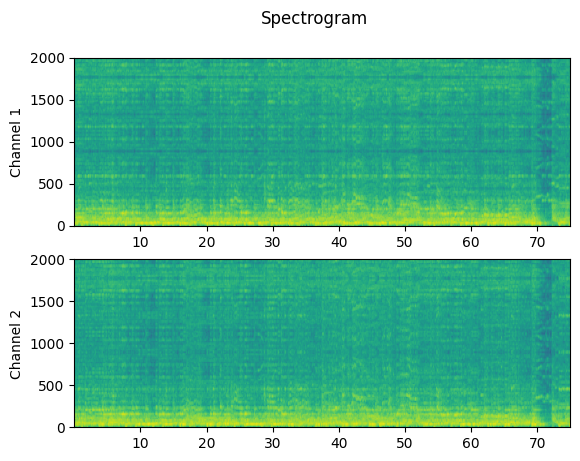

Sample Rate: 4000
Shape: (2, 300134)
Dtype: torch.float32
 - Max:      0.237
 - Min:     -0.211
 - Mean:     0.000
 - Std Dev:  0.046

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0494, -0.0517, -0.0517],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0625, -0.0466, -0.0466]])



In [3]:
# The path in the google drive
path = '/content/MyDrive/MyDrive/STAT_4984_(Deep_Learning)/final_project/Data 2/genres_original/'

# Visualize the data
music_ds = MusicDS(path)
waveform, frame_num, label = music_ds[100]
music_ds.plot_specgram(waveform, frame_num)
music_ds.print_stats(waveform, frame_num)

In [4]:
# Train/test split
test_size = int(len(music_ds) * 0.2)
train_size = int(len(music_ds) - test_size)

train_dataset, test_dataset = torch.utils.data.random_split(music_ds, 
                                                            [train_size, 
                                                             test_size])

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [5]:
# The model
class Net(nn.Module):
    def __init__(self, n_input = 2, n_output = 10, stride = 16, n_channel = 32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size = 80, 
                               stride = stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size = 3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size = 3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size = 3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size = 3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size = 3)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

In [6]:
# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

In [7]:
# Check that we're using cuda
device

device(type='cuda')

In [8]:
# Our optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.005, weight_decay = 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [9]:
# Function to train our model
def train(model, epoch):

    losses = []
    for batch_idx, (data, num, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data).to(device)

        loss = F.nll_loss(output.squeeze(), target)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses

In [10]:
# Some helper methods for validation
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim = -1)

# Function to validate our model on out of sample data
# Returns nested list: 1st entry is accuracy, 2nd entry contains a list
# 1st entry of 2nd entry is the actual values, 2nd entry of 2nd entry is the 
# predicted values
def test(model, epoch):
    model.eval()
    correct = 0

    for data, num, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data).to(device)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    accuracy = correct / len(test_loader.dataset)
    return [accuracy, [target, pred]]

In [11]:
n_epoch = 20

losses = []
accuracies = []

# Train the model (and test)
for epoch in range(1, n_epoch + 1):
    loss = train(net, epoch)
    losses.append(sum(loss) / len(loss))

    results = test(net, epoch)
    accuracies.append(results[0])
    scheduler.step()
    print(f'Epoch {epoch} / {n_epoch}, Accuracy = {accuracies[-1]}')

Epoch 1 / 20, Accuracy = 0.1
Epoch 2 / 20, Accuracy = 0.2
Epoch 3 / 20, Accuracy = 0.345
Epoch 4 / 20, Accuracy = 0.31
Epoch 5 / 20, Accuracy = 0.3
Epoch 6 / 20, Accuracy = 0.32
Epoch 7 / 20, Accuracy = 0.28
Epoch 8 / 20, Accuracy = 0.395
Epoch 9 / 20, Accuracy = 0.375
Epoch 10 / 20, Accuracy = 0.365
Epoch 11 / 20, Accuracy = 0.395
Epoch 12 / 20, Accuracy = 0.395
Epoch 13 / 20, Accuracy = 0.465
Epoch 14 / 20, Accuracy = 0.41
Epoch 15 / 20, Accuracy = 0.37
Epoch 16 / 20, Accuracy = 0.455
Epoch 17 / 20, Accuracy = 0.475
Epoch 18 / 20, Accuracy = 0.455
Epoch 19 / 20, Accuracy = 0.455
Epoch 20 / 20, Accuracy = 0.475


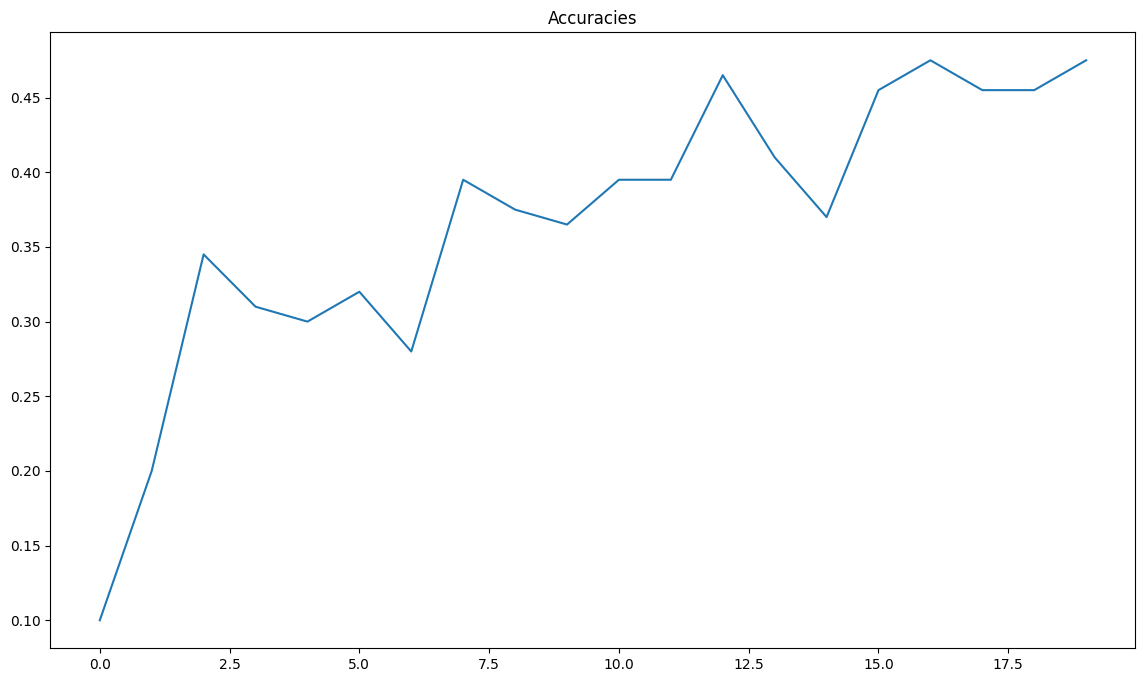

In [12]:
# Plot the accuracy
plt.figure(figsize = (14,8))
plt.title('Accuracies')
_ = plt.plot(accuracies)

In [13]:
# Save the final iteration of the model
torch.save(net.state_dict(), 'final_model.ckpt')

In [14]:
# Load the final model
S = torch.load('final_model.ckpt')
net.load_state_dict(S)

<All keys matched successfully>

In [36]:
# Summary of the model
print(net)

Net(
  (conv1): Conv1d(2, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn5): 